In [105]:
import torch
from torch import nn
import numpy as np
import operator
import torch.nn.functional as F
from functools import reduce
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
class SineLayer(nn.Module):

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        #coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output

In [89]:
class NOMAD_sine(nn.Module):
    def __init__(self, encnetdepth, decnetdepth, width,latent_size, coord_dim,insize,outsize,enc_activ = nn.GELU()):
        super(NOMAD_sine, self).__init__()

        inp_dim = insize
        elayers = []
        for i in range(encnetdepth):
            elayers.append(nn.Linear(inp_dim,width))
            elayers.append(enc_activ)
            inp_dim = width
        elayers.append(nn.Linear(inp_dim,latent_size))
        self.encoder = nn.Sequential(*elayers)
        self.decoder = Siren(latent_size+coord_dim,width,decnetdepth,outsize, outermost_linear=True)


    def forward(self, xenc,xcoord):
        #pdb.set_trace()
        xlat = self.encoder(xenc)
        xdec = torch.cat((xlat,xcoord),dim=1)
        x = self.decoder(xdec)
        return x

In [4]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        if p.requires_grad:
          c += reduce(operator.mul,
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [51]:

# Set random seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Define the functions
def f(x, xi):
    return (2.0 * torch.sin(2.0 * np.pi * x) + xi * torch.sin(16.0 * np.pi * x)) / (2.0 + xi)

T = torch.float32

# Generate random input data for training and testing
def generate_data(n_samples, num_pts):
    x = torch.linspace(0, 1, num_pts)
    xi = torch.rand(n_samples, 1)
    y = torch.zeros(n_samples, num_pts)
    for i in range(n_samples):
        y[i, :] = f(x, xi[i, 0])
    return x.reshape(-1,1).to(T), xi.to(T), y.to(T)


In [98]:
# Set the hyperparameters
batch_size = 100
learning_rate = 1e-4
num_epochs = 5000
num_pts = 100
n_train = 20
n_test = 10
num_feat = 0
inp_encsize = 1
latent_size = 2
coord_size = 1
out_size = 1
enc_activ = nn.GELU()
hid_neur = 50
decay = 1e-6

In [99]:
# Generate training data
x_train_init, xi_train, y_train_init = generate_data(n_train, num_pts)

# Generate testing data
x_test_init, xi_test, y_test_init = generate_data(n_test, num_pts)

x_enc_train = xi_train.repeat(1, num_pts).reshape(-1, 1)
x_coord_init = x_train_init.repeat(n_train, 1)
x_coord_train = x_coord_init  # Add feature augmentations if necessary
y_train = y_train_init.reshape(-1, 1)

x_enc_test = xi_test.repeat(1, num_pts).reshape(-1, 1)
x_testt_init = x_test_init.repeat(n_test, 1)
x_coord_test = x_testt_init  # Add feature augmentations if necessary
y_test = y_test_init.reshape(-1, 1)

# Convert data to PyTorch tensors
x_enc_train = x_enc_train.to(torch.float32)
x_coord_train = x_coord_train.to(torch.float32)
y_train = y_train.to(torch.float32)

x_enc_test = x_enc_test.to(torch.float32)
x_coord_test = x_coord_test.to(torch.float32)
y_test = y_test.to(torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(x_enc_train, x_coord_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(x_enc_test, x_coord_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [100]:
# Create an instance of the neural network
model = NOMAD_sine(encnetdepth=2, decnetdepth=2, width=hid_neur,latent_size=latent_size, coord_dim=coord_size,insize=inp_encsize,outsize=out_size)
# Define a loss function (mean squared error) and an optimizer (e.g., Adam)
loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
print(count_params(model))

8103


In [101]:
def train(model, dataloader, loss_function, optimizer):
    model.train()
    running_loss = 0.0
    for xenc, xcoord, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(xenc,xcoord)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [102]:
def test(model, dataloader, loss_function):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for xenc, xcoord, targets in dataloader:
            outputs = model(xenc,xcoord)
            loss = loss_function(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(dataloader)

In [103]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, loss_function, optimizer)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4E}\n")

    # Step the learning rate scheduler
    scheduler.step()

    test_loss= test(model, test_loader, loss_function)
    print(f"Test Loss: {test_loss:.4E}\n")

Streaming output truncated to the last 5000 lines.
Epoch [3751/5000] - Train Loss: 9.6881E-07

Test Loss: 1.3487E-06

Epoch [3752/5000] - Train Loss: 9.1648E-07

Test Loss: 9.6199E-07

Epoch [3753/5000] - Train Loss: 8.5538E-07

Test Loss: 1.1916E-06

Epoch [3754/5000] - Train Loss: 8.4227E-07

Test Loss: 7.8970E-07

Epoch [3755/5000] - Train Loss: 7.8611E-07

Test Loss: 1.1066E-06

Epoch [3756/5000] - Train Loss: 7.6690E-07

Test Loss: 7.2982E-07

Epoch [3757/5000] - Train Loss: 7.3310E-07

Test Loss: 1.0756E-06

Epoch [3758/5000] - Train Loss: 7.0497E-07

Test Loss: 7.5326E-07

Epoch [3759/5000] - Train Loss: 6.9516E-07

Test Loss: 1.0512E-06

Epoch [3760/5000] - Train Loss: 6.7233E-07

Test Loss: 8.0039E-07

Epoch [3761/5000] - Train Loss: 6.7735E-07

Test Loss: 1.0226E-06

Epoch [3762/5000] - Train Loss: 6.6711E-07

Test Loss: 8.3622E-07

Epoch [3763/5000] - Train Loss: 6.8969E-07

Test Loss: 1.0161E-06

Epoch [3764/5000] - Train Loss: 6.9827E-07

Test Loss: 8.6880E-07

Epoch [3765

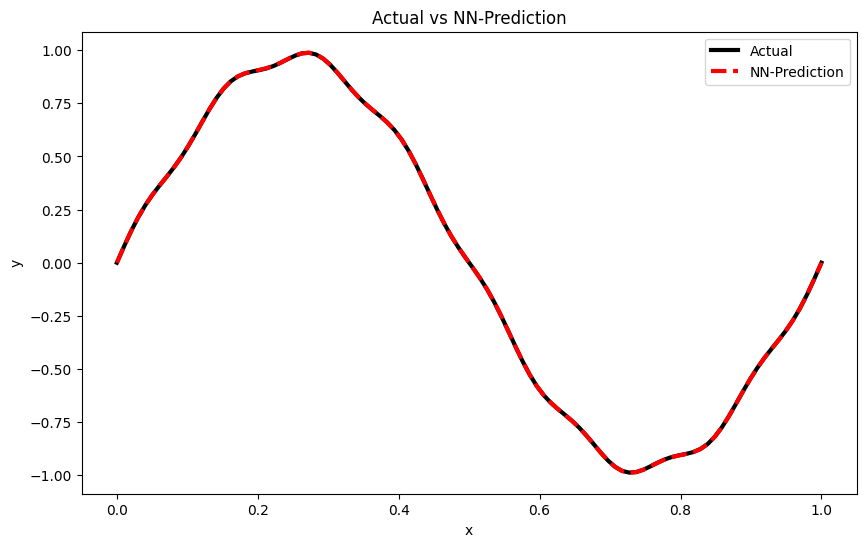

In [104]:
# Get the model predictions for test sample
output_pred_test = model(x_enc_test, x_coord_test).reshape(n_test,-1)
y_out_test = y_test.reshape(n_test,-1)

# Index for the sample to plot
n_idx = 1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_test_init[:,0].cpu().numpy(), y_out_test[n_idx,:].cpu().numpy(), label='Actual', color='black', linewidth=3)
plt.plot(x_test_init[:,0].cpu().numpy(), output_pred_test[n_idx,:].detach().cpu().numpy(), linestyle='--', label='NN-Prediction', color='red', linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Actual vs NN-Prediction')
plt.show()